# Data Sources and Files

We use the following data sources and/or files:
 1) "code/reverse_coords.ipynb": a . IPYNB file with the code used to perform convertion of the reversed coordinates
 
 2) "data/reverse_loc.pickle": a .PICKLE file with the reversed coordinates (*i.e.*, the name of the parish, city and district related to a given pair of coordinates)
 
 3) "data/df_reverse_coords.csv": a .CSV file with the reversed coordinates (*i.e.*, the name of the parish, city and district related to a given pair of coordinates)

# Introduction

## What is the problem?
As stated by the challenge provider in the official document, "*cities are flooded by countless outdoor advertising panels, often with a poor distribution*". Hence, we acknowledge that these visual aspects are crucial in the urban planning process since each plan choice can generate obstruction of urban elements, thus producing adverse effects on the city’s image.

## How do we relate this problem with the United Nations' Sustainable Development Goals (SDGs)?
Once again, we started by looking at the official document given by the challenge provider, which establishes a connection between this challenge and the **11th UN Sustainable Goal - Sustainable Cities and Communities**. From an attentive look at the scope of this 11th SDG, we can conclude that this is, somehow, related to the topic of "*Sustainable cities and human settlements*" (please refer to [https://sdgs.un.org/topics/sustainable-cities-and-human-settlements](https://sdgs.un.org/topics/sustainable-cities-and-human-settlements)). Since it is expected that the number of people in cities will grow significantly by 2050, it is of utmost importance that policy- and decision-makers define a sustainable strategy to assure that their cities have the right infrastructures to keep up with this development rate. We highlight two important ideas:
 - *Improving human settlements management*; 
 - *Promoting sustainable land-use planning and management*.

The ideas above are directly related to the proper organisation of outdoor advertising panels in cities in the sense that careful management may contribute to an increase of visual quality of streets and roads but also allows to increase the focus on the message and the announcement that the panel intends to transmit. Therefore, we agree that reducing the outdoor advertising visual impact in cities will contribute to minimising the reduction of the audience of the outdoor ad sector, thus improving the visual environment of cities and the sustainability of outdoor advertising activity.


## How do we propose to solve this problem?
We developed a metaheuristics-based algorithm (local/neighbourhood search) that optimises the outdoor-billboard density and the total number of views (*i.e.*, the number of outdoor billboards in a given radius). We start by creating neighbour solutions through swap operations in which we change the coordinates of a given billboard and assess the impact on hour fitness function, which takes this variable into account.

In the end, we are capable of proposing an alternative layout for the billboard location without needing to remove billboards. Why did we not want to remove billboards? Well, we do not know if by removing a billboard we are jeopardising the business of a given company. Therefore, we tried to keep our problem approach as simple as possible and thinking about the stakeholders as well.

# Development

## Packages to import and/or install

In [1]:
# !pip install pyshp
import pandas as pd
import pickle
from scipy.spatial import cKDTree
import numpy as np
import shapefile
from geopy import distance
from folium.plugins import FastMarkerCluster
import folium
import branca.colormap as cm 
from collections import defaultdict
from folium.plugins import HeatMap
from geopy.distance import distance
import seaborn as sns

# We created this variable to perform conversions of distances in KM to it's equivalent distance in the (lat, long) coordinate system
KMS_PER_RADIAN = 6371.0088

In [2]:
def read_shapefile(shp_path):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' column holding
    the geometry information. This uses the pyshp package
    """

    #read file, parse out the records and shapes
    sf = shapefile.Reader(shp_path)
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]

    #write into a dataframe
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)

    return df

We decided to perform a reverse coordinate conversion to have a clearer idea of the distribution of the billboards in the dataset. The next cells show that operation.

In [3]:
# Read shapefile with the ourdoor inventory

df = read_shapefile('data/outdoor_inventory/Outdoor_Inventory_AV.shp')

# Read pickle file containing mapping between coordinates and location (done in appendix)
reverse_coords_list = pd.read_pickle('data/reverse_loc.pickle')

# Map metadata regarding location
df['address_road'] = [x.get('address').get('road') for x in reverse_coords_list]
df['concelho'] = [x.get('address').get('town') for x in reverse_coords_list]
df['freguesia'] = [x.get('address').get('village') if 'village' in x.get('address') else x.get('address').get('neighbourhood') for x in reverse_coords_list]
df['distrito'] = [x.get('address').get('county') for x in reverse_coords_list]

# Determine if location is national road, highway or city center
df['address_road'] = df['address_road'].fillna('')
df['is_national_road'] = df['address_road'].str.contains('EN')
df['is_highway'] = df['address_road'].str.contains('Auto')
df['is_city_center'] = (~df['is_national_road']) & (~df['is_highway']) & (df['address_road'] != '')

In [4]:
df.head(3)

,PanelID,X,Y,Max_Visibi,Average_Da,coords,address_road,concelho,freguesia,distrito,is_national_road,is_highway,is_city_center
0,26144,-8.473975,40.900768,69,31.0,"[[-8.473975, 40.900768]]",Rua Alto das Casas,São João da Madeira,Macieira de Sarnes,Aveiro,False,False,True
1,11714,-9.315949,38.958125,69,31.0,"[[-9.315949, 38.958125]]",EN 9,Mafra,Barreiralva,Lisboa,True,False,False
2,26109,-8.510079,40.871821,69,32.0,"[[-8.510079, 40.871821]]",Rua Professor Doutor António Joaquim Ferreira ...,Oliveira de Azeméis,Vila de Cucujães,Aveiro,False,False,True


## Exploratory Data Analysis

The next cells present you an exploratory data analysis to give you some insights and/or intuition on the information we extracted before going into a "very algorithmic" approach.

We start by implementing several helper functions that will help us during the optimisation phase.

In [5]:
def find_neighbours_within_radius(xy, radius):
    """
    This function is used for returning the list of neighbours within a certain radius in a very efficient way.
    Inspirations: 
    
    # https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
    # https://stackoverflow.com/questions/43592094/efficient-way-to-calculate-geographic-density-in-pandas 
    # https://stackoverflow.com/questions/34579213/dbscan-for-clustering-of-geographic-location-data 
    
    For instance, between the coordinates (40.900768, -8.473975) and (40.214686, -8.432738) everything is counted as being within a 1.5km
        radius. The actual distance between them is 600m, determined using geopy.distance, not shown here.
        
    Args:
        xy (np.ndarray (N, 2)): Numpy array with the coordinates.
        radius (float): Radius in km.
    
    Returns:
        List[List[int]]: List of indexes representing the neighbors, for each element of the list.
    """
    tree = cKDTree(xy)
    within_radius = tree.query_ball_tree(tree, r=radius)
    return within_radius

def get_density_billboards(df, radius=1.5):
    """
    Calculate number of billboards in a X km radius for each point.
    
    Args:
        df (pd.DataFrame): Dataframe with list of panels + coordinates.
        radius (float): Radius to get density for.
    """
    
    df_copy = df.copy()

    neighbours_within_radius = find_neighbours_within_radius(
        np.radians(df_copy[['Y', 'X']].values), 
        radius/KMS_PER_RADIAN
    )

    df_copy['nbr_points_around_billboard'] = [len(x) for x in neighbours_within_radius]

    return df_copy, neighbours_within_radius

In [6]:
df, neighbours_within_radius = get_density_billboards(df)

In [7]:
df.head(3)

,PanelID,X,Y,Max_Visibi,Average_Da,coords,address_road,concelho,freguesia,distrito,is_national_road,is_highway,is_city_center,nbr_points_around_billboard
0,26144,-8.473975,40.900768,69,31.0,"[[-8.473975, 40.900768]]",Rua Alto das Casas,São João da Madeira,Macieira de Sarnes,Aveiro,False,False,True,25
1,11714,-9.315949,38.958125,69,31.0,"[[-9.315949, 38.958125]]",EN 9,Mafra,Barreiralva,Lisboa,True,False,False,9
2,26109,-8.510079,40.871821,69,32.0,"[[-8.510079, 40.871821]]",Rua Professor Doutor António Joaquim Ferreira ...,Oliveira de Azeméis,Vila de Cucujães,Aveiro,False,False,True,5


### Variability in Max Visibility

The "Max_Visibi" argument represents the maximum visibility for that billboard. It seems that the variability is very low - 81% of the billboards have a visibility of 69 meters, and 7% of 145 meters. As such, we opted for ignoring this parameter in the below optimization/calculation.

In [8]:
df['Max_Visibi'].value_counts(normalize=True)[0:5]

69     0.811621
145    0.071506
89     0.031111
78     0.023572
75     0.015407
Name: Max_Visibi, dtype: float64

### Determine the areas where we have a high amount of billboards on the exact same location

*1. Heatmap - Number of billboards at the exact same coordinate*

The heatmap below shows the number of billboards at the exact same coordinate.
The center of Lisbon, Porto and Faro are the areas where there are more billbords in the same coordinate (latitude, longitude). 
These are areas that have a lot of billboards piled up and on both sides of the street.

*2. Billboard density*

Within the same plot, we are displaying a cluster where you can see the overall billboard density. The displayed number changes whenever you zoom in/out.

**Overall conclusions**

You can see that there is a higher billboard density in the coast areas, while the interior of Portugal has a lot less billboards.
Lisbon and Porto, being large cities, have the highest amount of billboards. They also have more areas where there's a lot of billboards in the exact same (X,Y) coordinates, compared to other cities with less population density.

These are the cities where major action needs to be taken!

In [9]:
n_out = df[["X", "Y"]].value_counts().to_frame('n_OutdoorAd').reset_index()

m = folium.Map(location=[38.760398,-9.190202], zoom_start=7)

steps = 10
color_map = cm.linear.YlOrRd_09.scale(0, 1).to_step(steps)
gradient_map = defaultdict(dict)
for i in range(steps):
    gradient_map[1 / steps * i] = color_map.rgb_hex_str(1 / steps * i)


heatmap = HeatMap(
    list(zip(n_out["Y"], n_out["X"], n_out["n_OutdoorAd"])), gradient = gradient_map, radius=7)

color_map.add_to(m)
heatmap.add_to(m)
FastMarkerCluster(df[['Y', 'X']].values).add_to(m)

m

### Determine the areas where there's higher visibility

The heatmap below shows a representation of the average number of viewers per day. 
It can be seen that cities like Coimbra/Santarém display regions where there's a high number of billboard views.

These are regions where the billboard density is not as high compared to Porto/Lisbon.

In [10]:
mean_Average_Da = df.groupby(['X', 'Y']).agg({'Average_Da': 'mean'}).reset_index()

m1 = folium.Map(location=[38.760398,-9.190202], zoom_start=8)

heatmap = HeatMap(
    list(zip(mean_Average_Da["Y"],mean_Average_Da["X"], mean_Average_Da["Average_Da"])), gradient = gradient_map, radius=7)

color_map.add_to(m1)
heatmap.add_to(m1)

m1

## Metaheuristics: Billboard optimization

We now present you the algorithmic approach used to optimise the outdoor billboard. 

First, we calculate the average impressions per day for each location - as we might have the same coordinate with more than one billboard, due to overlap of billboards in the same direction of the road and in opposite directions. 

We start by defining our fitness function by two terms:

$f = avgden(df) - sumviews(df) $, where $avgden(df)$ is the average density of outdoor billboard in a given radius, and $sumviews(df)$ is the total sum of average viewers. In this case, our goal is to minimise the average density and maximize the total number of average billboard viewers.

Our proof-of-concept is focused on Lisboa, as it is one of the cities with higher billboard density.

In [11]:
# Focus on Lisbon

df_subset = df[df['distrito'] == 'Lisboa'].reset_index()

# We might have different impressions for the same coordinate (maybe diff directions of traffic?) so let's average it out

MEAN_IMPRESSIONS_PER_COORD = df_subset.groupby(['X', 'Y']).agg(
    {'freguesia': 'first',
     'distrito': 'first',
     'concelho': 'first',
     'Average_Da': 'mean'}).reset_index()

df_subset = df_subset[['PanelID', 'X', 'Y', 'Max_Visibi', 'Average_Da']]

MEAN_IMPRESSIONS_PER_COORD.head(2)

,X,Y,freguesia,distrito,concelho,Average_Da
0,-9.475810,38.815709,Colares,Lisboa,None,339.0
1,-9.470378,38.736197,Alcabideche,Lisboa,None,2285.0


In [12]:
def fitness(df, density_weight = 1, views_weight = 1/1e6):
    """
    Fitness function, which we want to minimize
    """
    
    # Get billboard density
    df, _ = get_density_billboards(df)

    max_density = df['nbr_points_around_billboard'].mean()
    total_number_of_views = df['Average_Da'].sum()
    
    max_density_loss = max_density*density_weight,
    views_loss = -total_number_of_views*views_weight
        
    
    total_loss = views_loss + max_density_loss

    return total_loss[0], {'avg_density_loss': max_density_loss, 'views_loss': views_loss}


# Get the fitness of the current subset
fitness(df_subset)

(289.1698587551596,
 {'avg_density_loss': (382.6084085051546,), 'views_loss': -93.438549749995})

#### Perturbation Operators

We have created two operators for perturbating our solution, by swapping the billboards' location. The new billboards will be placed at fixed coordinates, which are the locations present in `MEAN_IMPRESSIONS_PER_COORD`. Ideally, we would have a list of valid locations/estimation of number of views, but we don't. 

- Shuffle_Perturbation:  Randomly shuffles a subset of positions in the generated neighbors.
- Shuffle_Perturbation_With_Probs: Shuffles a subset of positions in the generated neighbors according to a given probability, which is given by their viewing density.

In [13]:
def shuffle_perturbation(neighbor, prob=0.1):
    """
    Randomly shuffles a subset of positions in the generated neighbors.

    It picks a neighbor and generates a new neighbour with some of its positions shuffled according to a given probability.

    Args:
        neighbor (pd.DataFrame): Dataframe with the positions for all the Panels.
        prob (float): Probability of each region being shuffled.

    Returns:
        (pd.DataFrame): Shuffled dataframe.
    """
    
    # Create a copy of the neighbor
    neighbor_copy = neighbor.copy()
    
    # Get the length of this neighbor
    neighbor_len = len(MEAN_IMPRESSIONS_PER_COORD)
    
    # Create a mask of the positions that will shuffle
    mask = np.random.random_sample((neighbor_len,)) <= prob
    mask = np.arange(neighbor_len)[mask]
    
    # Create a shuffled mask to change within these values
    shuffled_mask = mask.copy()
    
    # Shuffle this mask
    np.random.shuffle(shuffled_mask)
    
    # Create a variable with the coords that will be used to substitute
    final_coords = MEAN_IMPRESSIONS_PER_COORD.loc[shuffled_mask]

    # Perform the shuffle operation
    neighbor_copy.loc[mask, ['X', 'Y', 'Average_Da']] = final_coords[['X', 'Y', 'Average_Da']].values   

    return neighbor_copy

In [14]:
def shuffle_perturbation_with_probs(neighbor, subset_size_perc=0.1):
    """
    Shuffles a subset of positions in the generated neighbors according to a given probability, which is given by their viewing density.
    This should give priority to shuffling regions that have high billboard density first.
    
    It picks a neighbor and generates a new neighbour with some of its positions shuffled.
    
    Args:
        neighbor (pd.DataFrame): Dataframe with the positions for all the Panels.
        prob (float): Probability of each region being shuffled.
        
    Returns:
        (pd.DataFrame): Shuffled dataframe.
    """
    
    # Create a copy of the neighbor
    neighbor_copy = neighbor.copy()
    
    # Get the length of this neighbor
    neighbor_len = len(MEAN_IMPRESSIONS_PER_COORD)
    
    # The mask  of positions to shuffle is not random
    # We will create a mask with probabilities according to density
    _MEAN_IMPRESSIONS_PER_COORD = MEAN_IMPRESSIONS_PER_COORD.copy()
    _MEAN_IMPRESSIONS_PER_COORD["probs"] = _MEAN_IMPRESSIONS_PER_COORD["Average_Da"] / _MEAN_IMPRESSIONS_PER_COORD["Average_Da"].sum()
    
    # Create a list with indices
    indices = [i for i in range(neighbor_len)]
    # print(len(indices), neighbor_len)
    mask = np.random.choice(indices, size=int(subset_size_perc * neighbor_len), replace=True, p=_MEAN_IMPRESSIONS_PER_COORD["probs"].values)
    
    # Shuffle this mask
    shuffled_mask = mask.copy()
    
    # Shuffle this mask
    np.random.shuffle(shuffled_mask)

    # Create a variable with the coords that will be used to substitute
    final_coords = MEAN_IMPRESSIONS_PER_COORD.loc[shuffled_mask]

    # Perform the shuffle operation
    neighbor_copy.loc[mask, ['X', 'Y']] = final_coords[['X', 'Y']].values
    
    return neighbor_copy

### Apply perturbations on the initial solution for a set of iterations

In [16]:
np.random.seed(42)

best_fitness = np.inf
best_solution = df_subset

history_of_best_solutions = []

for iteration in range(100):
    
    # Get n random neighbours
    neighbors = best_solution
    
    # Probability of shuffle perturbation
    proba = np.random.randint(2)
    if proba == 1:
        neighbors = shuffle_perturbation(neighbors, 0.02)
       
    # Probability of balanced perturbation
    proba = np.random.randint(2)
    if proba == 1:
        neighbors = shuffle_perturbation_with_probs(neighbors, 0.02)
    
    # Convert to list
    neighbors = [neighbors]
    
    # Get fitnesses of possible solutions
    fitness_neighbours = [fitness(x)[0] for x in neighbors]
    
    neighbour_lower_fitness_idx = np.argmin(fitness_neighbours)
    fitness_neighbour_lower_fitness = fitness_neighbours[neighbour_lower_fitness_idx]
    neighbour_lower_fitness = neighbors[neighbour_lower_fitness_idx]
    
    if fitness_neighbour_lower_fitness < best_fitness:
        best_fitness = fitness_neighbour_lower_fitness
        best_solution = neighbour_lower_fitness
        
        history_of_best_solutions.append(best_solution)

        print("Found a better solution!")
        
    print("Epoch %d | Fitness %f" % (iteration, best_fitness))

Found a better solution!
Epoch 0 | Fitness 290.549208
Epoch 1 | Fitness 290.549208
Epoch 2 | Fitness 290.549208
Epoch 3 | Fitness 290.549208
Epoch 4 | Fitness 290.549208
Epoch 5 | Fitness 290.549208
Epoch 6 | Fitness 290.549208
Epoch 7 | Fitness 290.549208
Epoch 8 | Fitness 290.549208
Epoch 9 | Fitness 290.549208
Epoch 10 | Fitness 290.549208
Epoch 11 | Fitness 290.549208
Epoch 12 | Fitness 290.549208
Epoch 13 | Fitness 290.549208
Epoch 14 | Fitness 290.549208
Epoch 15 | Fitness 290.549208
Epoch 16 | Fitness 290.549208
Found a better solution!
Epoch 17 | Fitness 290.281915
Epoch 18 | Fitness 290.281915
Found a better solution!
Epoch 19 | Fitness 290.001017
Epoch 20 | Fitness 290.001017
Found a better solution!
Epoch 21 | Fitness 287.518492
Found a better solution!
Epoch 22 | Fitness 287.448704
Epoch 23 | Fitness 287.448704
Epoch 24 | Fitness 287.448704
Epoch 25 | Fitness 287.448704
Epoch 26 | Fitness 287.448704
Epoch 27 | Fitness 287.448704
Epoch 28 | Fitness 287.448704
Found a better 

In [17]:
fitness(best_solution)

(275.39762668385464,
 {'avg_density_loss': (372.93427835051546,), 'views_loss': -97.53665166666083})

In [ ]:
# Write to .csv so we don't need to run everything again
best_solution.to_csv('data/best_solution.csv')

### How is the new solution different from the previous one?

Let's start by representing the changes in coordinates.

In [18]:
best_solution = pd.read_csv('data/best_solution.csv')

In [19]:
COLS = ['PanelID', 'X', 'Y', 'Max_Visibi', 'Average_Da']

In [20]:
# Merge by the PanelID, to see where the new PanelID is placed

diff_solutions = df[COLS].merge(best_solution[COLS], on=['PanelID'], suffixes=(('', '_new')))
diff_solutions = diff_solutions[
    (diff_solutions['X'] != diff_solutions['X_new']) & (diff_solutions['Y'] != diff_solutions['Y_new'])
]

In [21]:
# Get location

diff_solutions = diff_solutions.merge(MEAN_IMPRESSIONS_PER_COORD[['freguesia', 'concelho', 'distrito', 'X', 'Y']], on=['X', 'Y'], how='left')

In [22]:
# Get new location metadata

diff_solutions = diff_solutions.merge(
    MEAN_IMPRESSIONS_PER_COORD[['freguesia', 'concelho', 'distrito', 'X', 'Y']], 
    left_on=['X_new', 'Y_new'],
    right_on=['X', 'Y'],
    how='left',
    suffixes=(('', '_new'))
)

# Remove duplicate columns
diff_solutions = diff_solutions.loc[:, ~diff_solutions.columns.duplicated()]
diff_solutions = diff_solutions.fillna('')

In [23]:
diff_solutions.head(2)

,PanelID,X,Y,Max_Visibi,Average_Da,X_new,Y_new,Max_Visibi_new,Average_Da_new,freguesia,concelho,distrito,freguesia_new,concelho_new,distrito_new
0,26317,-9.216424,38.780164,69,36.0,-9.243129,38.723455,69,7179.0,,,Lisboa,Bairro do Aqueduto,,Lisboa
1,27178,-9.322304,38.830235,69,37.0,-9.322304,38.830235,69,37.0,Algueirão-Mem Martins,,Lisboa,,,


### What is the impact of our current solution?

Let's check both parts of the fitness function.

The average density in a 1.5km radius reduced from 382.6 to 372.9 billboards, while the views loss decreased from -93.4 to -97.5.
This shows that our algorithm is effectively reducing both terms of our loss function: the negative of the total sum of the daily views and the average billboard density.

We have proposed the change of location of 5163 billboards, which leads to an average increase in the daily viewers of 793 people for each billboard, for the ones we change.

In [24]:
print("Starting solution:", fitness(df_subset)[1])
print("Best solution:", fitness(best_solution)[1])

Starting solution: {'avg_density_loss': (382.6084085051546,), 'views_loss': -93.438549749995}
Best solution: {'avg_density_loss': (372.93427835051546,), 'views_loss': -97.53665166666083}


In [25]:
print("Difference in the average number of daily viewers", (diff_solutions['Average_Da_new'] - diff_solutions['Average_Da']).mean())
print("Number of moved billboards:", diff_solutions.shape[0])

Difference in the average number of daily viewers 793.7443185484858
Number of moved billboards: 5163


Considering that the average fuel consumption of a passenger car is equal to [5.8 liters/100 km](https://zero.ong/automoveis-conheca-as-diferencas-entre-consumos-anunciados-e-reais/) and that the average price of gasoline [is equal to 1.598 euros/liter (data from 24-May-2021)](https://pt.globalpetrolprices.com/Portugal/gasoline_prices/), we can then calculate an estimate of the money spent on billboard transportation.

For simplification purposes, let's assume a single car transports each billboard and needs to do a trip in both directions (of course, won't happen in real life). 

The total travel cost for transporting the billboards is around 10k€. However, this means we'll be having around 637 viewers/€ extra.

An American research noted that [58% of Americans](https://imagine-express.com/billboard-advertising-effective/) learned about an event or restaurant they were interested in attending by viewing a roadside billboard. So, the extra active amount of viewers we get is closer to 370 viewers/€. 


In [26]:
def distance_calc(row):
    """
    Calculates the distance in km between two points
    """
    start = (row['Y'], row['X'])
    stop = (row['Y_new'], row['X_new'])

    return distance(start, stop).kilometers

# Calculate distance in km and travel cost per billboard
diff_solutions['distance_km'] = diff_solutions.apply(lambda row: distance_calc (row),axis=1)
diff_solutions['distance_km_2x'] = diff_solutions['distance_km'] * 2
diff_solutions['travel_cost_euros'] = diff_solutions['distance_km_2x'] * 0.058 * 1.598

print("Total travel cost (€)", diff_solutions['travel_cost_euros'].sum())

tmp = (diff_solutions['Average_Da_new'] - diff_solutions['Average_Da']) / (diff_solutions['travel_cost_euros'])
print("Number of extra viewers per euro", tmp.mean())

engaged_users = 0.58
print("Number of extra engaged per euro", engaged_users * tmp.mean())

Total travel cost (€) 10331.627371983768
Number of extra viewers per euro 637.5471195961551
Number of extra engaged per euro 369.7773293657699


We now plot the transitions of billboards between cities, filtering the cases where we have no nulls. We have a lot of nulls from our reverse geocoding algorithm so there's not much conclusions we can take from this.

Percentage of cases filtered: 0.9922525663374008


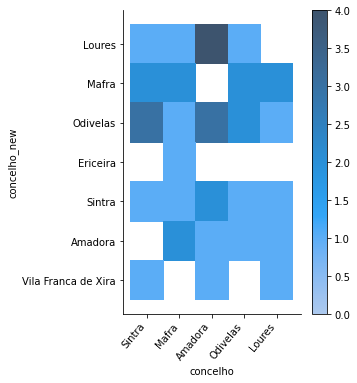

In [27]:
mask = (diff_solutions.concelho != '') & (diff_solutions.concelho_new != '')

print("Percentage of cases filtered:", 1 - mask.mean())
g = sns.displot(diff_solutions[mask], x="concelho", y="concelho_new", cbar=True)
g.set_xticklabels(rotation=50, ha='right')

# Conclusion

## Scalability and Impact

### Scalability

We believe that this optimisation model can be one of the modules of a decision support system that could benefit two distinct stakeholders:

**1. Policy-makers (*e.g.* the public management intervenients of the municipalities):**

Assuming that most of the billboards are placed in areas (*i.e.*, territory) that concern public management, this kind of model could help decision-makers in the regions that could be given to new market players/entities to place specific billboards. While optimising the quality of life in cities, this could also optimise the management process.

**2. Advertising Companies:**

Once again, we envision that this model would be integrated into a decision support system that could advise companies on places with good potential that may be underestimated. This way, companies could get a better measure of their competitors and could leverage potential places, thus benefitting/increasing the quality of their investment and helping (at the same time) the sustainable paradigm we intend to implement in cities. 

Finally, there could be a cooperation between policy makers and advertising companies to pay part of the transportation costs, in order to move billboards to less crowded locations, but with a lot of visibility as well.

### Impact

#### Advertising Investments
In 2017, advertising investments made in outdoor represented 11.7% of the market [according to Omnicom data](https://obercom.pt/wp-content/uploads/2019/05/Publicidade_2019_Final.pdf](https://obercom.pt/wp-content/uploads/2019/05/Publicidade_2019_Final.pdf). This percentage is mostly due to the knowledge of the advantages of this type of advertising, such as the great effectiveness in reach (it is a form of advertising without interruption since it remains on display 24 hours a day) and the [power to reach different parts of the city, social classes and age groups](https://www.adquick.com/blog/what-are-the-benefits-of-outdoor-advertising/](https://www.adquick.com/blog/what-are-the-benefits-of-outdoor-advertising/).

#### Outdoor Advertising Media Coverage
A recent study by the company PSE shows that the outdoor advertising media has close to 90% coverage. With the new confinement decreed in January, both coverage and frequency have naturally decreased, resulting in a lower audience production. However, [this audience is still high, around 50,000 viewers]([https://www.meiosepublicidade.pt/2021/02/estudo-audiencias-outdoor-ja-mede-80-cento-dos-suportes-portugal/](https://www.meiosepublicidade.pt/2021/02/estudo-audiencias-outdoor-ja-mede-80-cento-dos-suportes-portugal/)).

#### Outdoor Advertising Media Costs
The annual corporate outdoor advertising media cost was [in 2019, equal to €89 534](https://www.ine.pt/xportal/xmain?xpid=INE&xpgid=ine_indicadores&indOcorrCod=0006846&contexto=bd&selTab=tab2&xlang=PT). By switching the position of billboards to positions with lower billboard density and higher visibility, we gain viewers at a rate of 370 viewers/€, considering that the average rental cost remains fixed. The calculations are available on the section "What's the impact of the current solution", in the development part.

## Future Work

It would be interesting to have information related to:

 - Distribution of the billboards per company (the concession): with this data, we could optimise our algorithm by taking into account the distribution of billboards in a given radius per company (*i.e.*, ideally, we want the billboards to be uniformly distributed along that area).

 - Actual billboard coverage in the dataset: this data would help us to refine the optimisation algorithm since we could create a different restriction in the fitness function (*e.g.*, we do not want to minimise the billboard coverage in the dataset, therefore, the best solution, could not be created by neighbours that would "contain" this issue).